# Introduction
Once the pre-processing is done, then it's time to start training the model.

In this notebook we will se how to establish a training workflow that reads images and masks in batches, feeds them to the model, updates the model's parameters and then repeats this pipeline until convergence. This is particularly important so to make efficient use of computing resources.

Also, we will show some visualisation of training history output.

### Imports
Import libraries and write settings here.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30
pd.options.display.float_format = '{:,.4f}'.format

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import seaborn as sns
#import plotly.plotly as py
#import plotly.graph_objs as go
#from plotly.offline import iplot, init_notebook_mode
#init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

/home/luca/anaconda3/envs/tensorflow/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:558: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis


/home/luca/anaconda3/envs/tensorflow/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:531: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis




## General packages

In [2]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, Model, Sequential
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import Input, Dropout, Activation, Conv2D, MaxPooling2D, UpSampling2D, Lambda, BatchNormalization
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import callbacks, initializers, layers, models, optimizers
from keras import backend as K

import random

Using TensorFlow backend.


## Custom modules 

In [3]:
import sys
code_path = "../code"
sys.path.append(code_path)

from config_script import *
from augmentation import custom_augmenter
import training

# Analysis/Modeling

## Training pipeline 

First of all we have to establish a workflow from data reading to data feeding into the network. 

In [4]:
# create path to store validation images separately
valid_img_path = RAW_DATA_PATH / "sample_valid/all_images/images"
valid_masks_path = RAW_DATA_PATH / "sample_valid/all_masks/images"
valid_img_path.mkdir(parents=True, exist_ok=True)
valid_masks_path.mkdir(parents=True, exist_ok=True)

In [5]:
t, v, seed = training.setup_pipeline(custom_augmentation=custom_augmenter, training_img_path=SAMPLE_IMG_PATH,
                                    training_masks_path=SAMPLE_MASKS_PATH, valid_img_path=SAMPLE_IMG_PATH,
                                    valid_masks_path=SAMPLE_MASKS_PATH, IMG_HEIGHT=512,IMG_WIDTH=512,
                                    val_percentage=0.3, color='rgb', BATCH_SIZE=3, VALID_BATCH_SIZE=3, seed=None)

Found 17 images belonging to 1 classes.
Found 17 images belonging to 1 classes.
Found 7 images belonging to 1 classes.
Found 7 images belonging to 1 classes.


## Model definition 

Once a training pipeline is setup, the next step is to define a model and to start the learning process.

In [8]:
unet = training.make_UNet()
unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 84          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 1 448         conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 1 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
dropout_1 

In [4]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.2, 0.8, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# dice loss


def dice_coef(y_true, y_pred):
    """Generate the 'Dice' coefficient for the provided prediction.
    Args:
        y_true: The expected/desired output mask.
        y_pred: The actual/predicted mask.
    Returns:
        The Dice coefficient between the expected and actual outputs. Values
        closer to 1 are considered 'better'.
    """
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    """Model loss function using the 'Dice' coefficient.
    Args:
        y_true: The expected/desired output mask.
        y_pred: The actual/predicted mask.
    Returns:
        The corresponding loss, related to the dice coefficient between the expected
        and actual outputs. Values closer to 0 are considered 'better'.
    """
    return -dice_coef(y_true, y_pred)

## Set training hyperparameters 

In [10]:
# set training hyperparameters

# STEPS_PER_EPOCH = 10
ADAM = optimizers.Adam(lr=0.001)
checkpointer = ModelCheckpoint(
    str(MODEL_CHECKPOINTS/'UNet_RGB_notebook_AML.h5'), verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=5)
# tensorboard = TensorBoard(log_dir=str(RESULTS_DIRECTORY/'logs'), histogram_freq=0, write_graph=True, write_images=False)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=2, verbose=1)
CALLBACKS = [checkpointer, earlystopping, reduce_lr]  # , tensorboard]


## Run the model 

In [13]:
model, results = training.train(model=unet, train_generator=t, valid_generator=v, optimizer=ADAM, 
                                loss='binary_crossentropy', custom_metrics=[mean_iou, dice_coef], 
                                callbacks=CALLBACKS, epochs=200, train_steps=80, valid_steps=30,
                                save_history=False, history_path=None)

Epoch 1/200
80/80 [==============================] - 47s 587ms/step - loss: 0.2090 - mean_iou: 0.4411 - dice_coef: 0.0114 - val_loss: 0.1074 - val_mean_iou: 0.4795 - val_dice_coef: 0.0130

Epoch 00001: val_loss improved from 0.47986 to 0.10742, saving model to ../results/model_checkpoints/UNet_RGB_notebook_AML.h5
Epoch 2/200
80/80 [==============================] - 40s 503ms/step - loss: 0.0798 - mean_iou: 0.4863 - dice_coef: 0.0107 - val_loss: 0.0632 - val_mean_iou: 0.4899 - val_dice_coef: 0.0123

Epoch 00002: val_loss improved from 0.10742 to 0.06321, saving model to ../results/model_checkpoints/UNet_RGB_notebook_AML.h5
Epoch 3/200
80/80 [==============================] - 42s 531ms/step - loss: 0.0527 - mean_iou: 0.4917 - dice_coef: 0.0101 - val_loss: 0.0493 - val_mean_iou: 0.4930 - val_dice_coef: 0.0106

Epoch 00003: val_loss improved from 0.06321 to 0.04931, saving model to ../results/model_checkpoints/UNet_RGB_notebook_AML.h5
Epoch 4/200
80/80 [==============================] - 43

# Training history 

Let now see how the loss function and the custom metrics evolved during training.

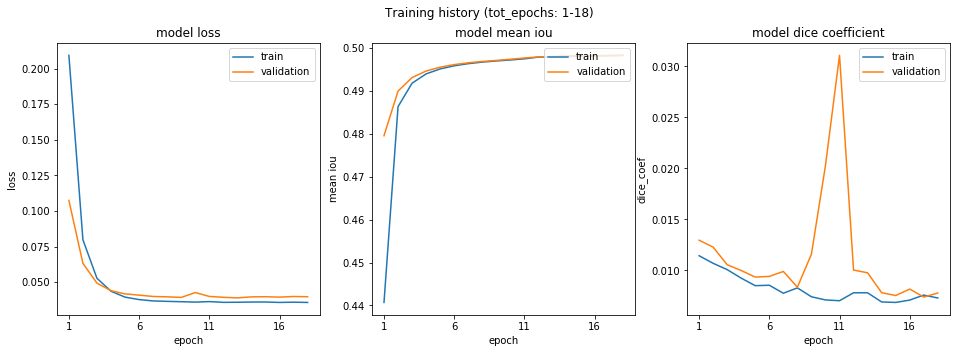

In [29]:
training.plot_metrics_history(results, results.shape[0] )

Despite a slight difference in the quantities computed in the training set and the ones computed in the validation set, the trend of the curves are pretty much the same. This is a signal that we should not be in an overfitting regime. 

As far as the actual loss values, it is difficult to interpret whether an order of magnitute around 0.039 is syntom of good performances. On the other hand, custom metrics indeed assume low values, thus testifying for a poor fit.